# Hemolytic Activity Prediction of Peptide with XAI

Neural network predictions are not interpretable in general, but they can be made interpretable with XAI (explainable AI).After all, being able to understand model predictions is justified from a practical, theoretical, and increasingly a regulatory stand-point.

It is practical because it has been shown that people are more likely to use predictions of a model if they can understand the rationale. Another practical concern is that correctly implementing methods is much easier when one can understand how a model arrived at a prediction. A theoretical justification for transparency is that it can help identify incompleteness in model domains (i.e., covariate shift)

For feature wise explanaton, we use a mathematical concept called Shapley values.It comes from game theory and are a solution to how to pay a coalition of cooperating players according to their contributions. Imagine each feature is a player and we would like to “pay” them according to their contribution to the predicted value.

In [48]:
import haiku as hk
import jax
import tensorflow as tf
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import urllib
from functools import partial
from jax.example_libraries import optimizers as opt
import keras

In [ ]:
pip install -U dm-haiku

In [4]:
np.random.seed(0)
tf.random.set_seed(0)

# amino acids
ALPHABET = [
    "-",
    "A",
    "R",
    "N",
    "D",
    "C",
    "Q",
    "E",
    "G",
    "H",
    "I",
    "L",
    "K",
    "M",
    "F",
    "P",
    "S",
    "T",
    "W",
    "Y",
    "V",
]

In [5]:
# We now define a few functions to convert between amino acid sequence and one-hot vectors.
def seq2array(seq, L=200):
    return np.pad(list(map(ALPHABET.index, seq)), (0, L - len(seq))).reshape(1, -1)


def array2oh(a):
    a = np.squeeze(a)
    o = np.zeros((len(a), 21))
    o[np.arange(len(a)), a] = 1
    return o.astype(np.float32).reshape(1, -1, 21)


# retreieving the data

with np.load("../data/hemolytic.npz", "rb") as r:
    pos_data, neg_data = r["positives"], r["negatives"]

We use the feature importance methods on a peptide prediction task to predict if a peptide will kill red blood cells (hemolytic).The model takes in peptides sequences (e.g., DDFRD) and predicts the probability that the peptide is hemolytic. The goal of the feature importance method here will be to identify which amino acids matter most for the hemolytic activity.

We build the convolution model in Jax (using Haiku) to make working with gradients a bit easier. We pass in the sequence length and amino acid fractions as extra information in addition to the convolutions.



In [11]:
# create labels and stich it all into one
# tensor
labels = np.concatenate(
    (
        np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
# we now need to shuffle before creating TF dataset
# so that our train/test/val splits are random
i = np.arange(len(labels))
np.random.shuffle(i)
labels = labels[i]
features = features[i]
L = pos_data.shape[-2]

# need to add token for empty amino acid
# dataset just has all zeros currently
features = np.concatenate((np.zeros((features.shape[0], L, 1)), features), axis=-1)
features[np.sum(features, -1) == 0, 0] = 1.0

batch_size = 16
full_data = tf.data.Dataset.from_tensor_slices((features.astype(np.float32), labels))

# now split into val, test, train
N = pos_data.shape[0] + neg_data.shape[0]
split = int(0.1 * N)
test_data = full_data.take(split).batch(batch_size)
nontest = full_data.skip(split)
val_data, train_data = nontest.take(split).batch(batch_size), nontest.skip(
    split
).shuffle(1000).batch(batch_size)

In [9]:
# we will define our own custom functions

def binary_cross_entropy(logits, y):
    """Binary cross entropy without sigmoid. Works with logits directly"""
    return (
        jnp.clip(logits, 0, None) - logits * y + jnp.log(1 + jnp.exp(-jnp.abs(logits)))
    )


def model_fn(x):
    # get fractions, excluding skip character
    aa_fracs = jnp.mean(x, axis=1)[:, 1:]
    # compute convolutions/poolings
    mask = jnp.sum(x[..., 1:], axis=-1, keepdims=True)
    for kernel, pool in zip([5, 3, 3], [4, 2, 2]):
        x = hk.Conv1D(16, kernel)(x) * mask
        x = jax.nn.tanh(x)
        x = hk.MaxPool(pool, pool, "VALID")(x)
        mask = hk.MaxPool(pool, pool, "VALID")(mask)
    # combine fractions, length, and convolution ouputs
    x = jnp.concatenate((hk.Flatten()(x), aa_fracs, jnp.sum(mask, axis=1)), axis=1)
    # dense layers. no bias, so zeros give P=0.5
    logits = hk.Sequential(
        [
            hk.Linear(256, with_bias=False),
            jax.nn.tanh,
            hk.Linear(64, with_bias=False),
            jax.nn.tanh,
            hk.Linear(1, with_bias=False),
        ]
    )(x)
    return logits


model = hk.without_apply_rng(hk.transform(model_fn))


def loss_fn(params, x, y):
    logits = model.apply(params, x)
    return jnp.mean(binary_cross_entropy(logits, y))


@jax.jit
def hemolytic_prob(params, x):
    logits = model.apply(params, x)
    return jax.nn.sigmoid(jnp.squeeze(logits))


@jax.jit
def accuracy_fn(params, x, y):
    logits = model.apply(params, x)
    return jnp.mean((logits >= 0) * y + (logits < 0) * (1 - y))

In [12]:
rng = jax.random.PRNGKey(0)
xi, yi = features[:batch_size], labels[:batch_size]
params = model.init(rng, xi)

opt_init, opt_update, get_params = opt.adam(1e-2)
opt_state = opt_init(params)


@jax.jit
def update(step, opt_state, x, y):
    value, grads = jax.value_and_grad(loss_fn)(get_params(opt_state), x, y)
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

/usr/local/lib/python3.10/dist-packages/haiku/_src/initializers.py:127: UserWarning: Explicitly requested dtype float64  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  unscaled = jax.random.truncated_normal(
/usr/local/lib/python3.10/dist-packages/haiku/_src/base.py:658: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


In [13]:
# We next train the model for 32 epochs
epochs = 32
for e in range(epochs):
    avg_v = 0
    for i, (xi, yi) in enumerate(train_data):
        v, opt_state = update(i, opt_state, xi.numpy(), yi.numpy())
        avg_v += v
opt_params = get_params(opt_state)


def predict(x):
    return jnp.squeeze(model.apply(opt_params, x))


def predict_prob(x):
    return hemolytic_prob(opt_params, x)

We try an amino acid sequence, a peptide, to get a feel for the model. The model outputs logits (logarithm of odds), which we put through a sigmoid to get probabilities. The peptides must be converted from a sequence to a matrix of one-hot column vectors. We’ll try two known sequences: Q is known to be common in hemolytic residues and the second sequence is poly-G, which is the simplest amino acid.

In [14]:
s = "QQQQQ"
sm = array2oh(seq2array(s))
p = predict_prob(sm)
print(f"Probability {s} of being hemolytic {p:.2f}")

s = "GGGGG"
sm = array2oh(seq2array(s))
p = predict_prob(sm)
print(f"Probability {s} of being hemolytic {p:.2f}")

Probability QQQQQ of being hemolytic 1.00
Probability GGGGG of being hemolytic 0.00


In [15]:
# Computing the accuracy of the model

acc = []
for xi, yi in test_data:
    acc.append(accuracy_fn(opt_params, xi.numpy(), yi.numpy()))
print(jnp.mean(np.array(acc)))

0.95208335


Now to start examining why a particular sequence is hemolytic! We’ll begin by computing the gradients with respect to input – the naieve approach that is susceptible to shattered gradients. We will use a more complex peptide sequence that is known to be hemolytic to get more interesting analysis.

In [16]:
def plot_grad(g, s, ax=None):
    # g = np.array(g)
    if ax is None:
        plt.figure()
        ax = plt.gca()
    if len(g.shape) == 3:
        h = g[0, np.arange(len(s)), list(map(ALPHABET.index, s))]
    else:
        h = g
    ax.bar(np.arange(len(s)), height=h)
    ax.set_xticks(range(len(s)))
    ax.set_xticklabels(s)
    ax.set_xlabel("Amino Acid $x_i$")
    ax.set_ylabel(r"Gradient $\frac{\partial \hat{f}(\vec{x})}{\partial x_i}$")

In [17]:
s = "RAGLQFPVGRLLRRLLRRLLR"
sm = array2oh(seq2array(s))
p = predict_prob(sm)
print(f"Probability {s} of being hemolytic {p:.2f}")

Probability RAGLQFPVGRLLRRLLRRLLR of being hemolytic 1.00


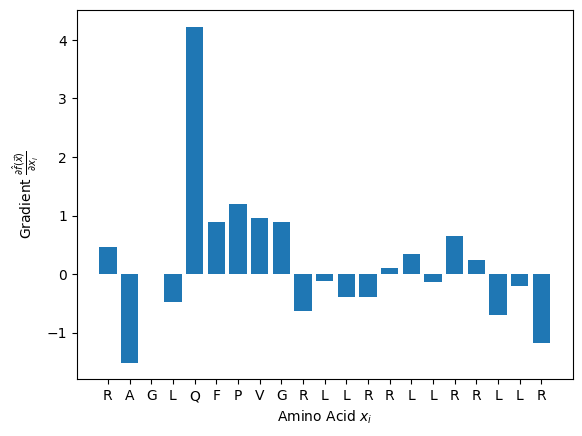

In [18]:
# computing the gradients

gradient = jax.grad(predict, 0)
g = gradient(sm)
plot_grad(g, s)

We can see a strong position dependence on the leucine (L) and arginine (R).

We’ll now implement the integrated gradients method. We have to go through three basic steps:

1. Create an array of inputs going from baseline to input peptide

2. Evaluate gradient on each input

3. Compute the sum of the gradients and multiply it by difference between baseline and peptide

The baseline for us is all zeros – which gives a probability of 0.5 (logits = 0, a model root). This baseline is exactly on the decision boundary.

In [19]:
def integrated_gradients(sm, N):
    baseline = jnp.zeros((1, L, 21))
    t = jnp.linspace(0, 1, N).reshape(-1, 1, 1)
    path = baseline * (1 - t) + sm * t

    def get_grad(pi):
        # compute gradient
        # add/remove batch axes
        return gradient(pi[jnp.newaxis, ...])[0]

    gs = jax.vmap(get_grad)(path)
    # sum pieces (Riemann sum), multiply by (x - x')
    ig = jnp.mean(gs, axis=0, keepdims=True) * (sm - baseline)
    return ig


ig = integrated_gradients(sm, 1024)

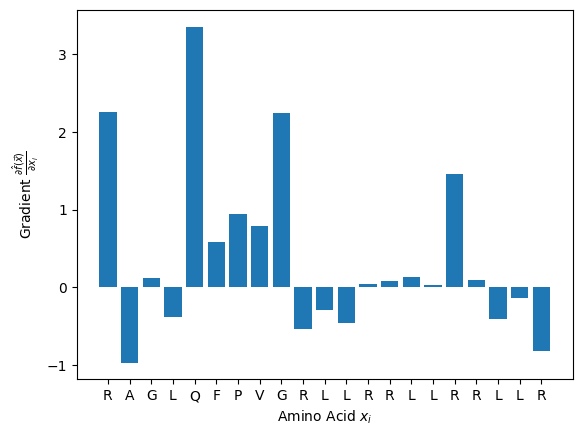

In [20]:
plot_grad(ig, s)

We see that the position dependence has become more pronounced, with arginine being very sensitive to position. Relatively little has qualitatively changed between this and the vanilla gradients.

We now do SmoothGrad, the steps are almost identicial:

1. Create an array of inputs that are random pertubations of the input peptide

2. Evaluate gradient on each input

3. Compute the mean of the gradients

There is one additional hyperparameter,
, which in principle should be as small as possible while still causing the model output to change.

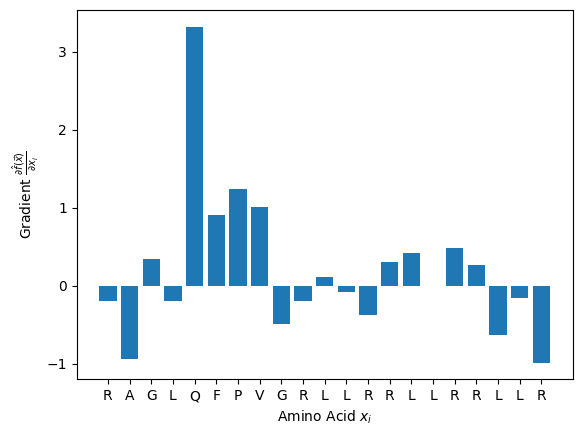

In [21]:
def smooth_gradients(sm, N, rng, sigma=1e-3):
    baseline = jnp.zeros((1, L, 21))
    t = jax.random.normal(rng, shape=(N, sm.shape[1], sm.shape[2])) * sigma
    path = sm + t
    # remove examples that are negative and force summing to 1
    path = jnp.clip(path, 0, 1)
    path /= jnp.sum(path, axis=2, keepdims=True)

    def get_grad(pi):
        # compute gradient
        # add/remove batch axes
        return gradient(pi[jnp.newaxis, ...])[0]

    gs = jax.vmap(get_grad)(path)
    # mean
    ig = jnp.mean(gs, axis=0, keepdims=True)
    return ig


sg = smooth_gradients(sm, 1024, jax.random.PRNGKey(0))
plot_grad(sg, s)

It looks remarkably similar to the vanilla gradient setting – probably because our 1D input/shallow network is not as sensitive to shattered gradients.

Now we will approximate the Shapley values for each feature. The Shapley value computation is different than previous approaches because it does not require gradients. The basic algorithm is:

1. select random point x’

2. create point z by combining x and x’

3. compute change in predicted function

One efficiency change we make is to prevent modifying the sequence in its padding – basically prevent exploring making the sequence longer.

In [22]:
def shapley(i, sm, sampled_x, rng, model):
    M, F, *_ = sampled_x.shape
    z_choice = jax.random.bernoulli(rng, shape=(M, F))
    # only swap out features within length of sm
    mask = jnp.sum(sm[..., 1:], -1)
    z_choice *= mask
    z_choice = 1 - z_choice
    # construct with and w/o ith feature
    z_choice = z_choice.at[:, i].set(0.0)
    z_choice_i = z_choice.at[:, i].set(1.0)
    # select them via multiplication
    z = sm * z_choice[..., jnp.newaxis] + sampled_x * (1 - z_choice[..., jnp.newaxis])
    z_i = sm * z_choice_i[..., jnp.newaxis] + sampled_x * (
        1 - z_choice_i[..., jnp.newaxis]
    )
    v = model(z_i) - model(z)
    return jnp.squeeze(jnp.mean(v, axis=0))


# assuming data is alrady shuffled, so we just take M
M = 4096
sl = len(s)
sampled_x = train_data.unbatch().batch(M).as_numpy_iterator().next()[0]
# make batched shapley so we can compute for all features
bshapley = jax.vmap(shapley, in_axes=(0, None, None, 0, None))
sv = bshapley(
    jnp.arange(sl),
    sm,
    sampled_x,
    jax.random.split(jax.random.PRNGKey(0), sl),
    predict,
)

# we now compute global expectation
eyhat = 0
for xi, yi in full_data.batch(M).as_numpy_iterator():
    eyhat += jnp.mean(predict(xi))
eyhat /= len(full_data)

One nice check on Shapley values is that we can check that their sum is equal to the value of model function minus the expect value across all instances.We can compute that value as:

In [23]:
print(np.sum(sv), predict(sm))

# There is a disagreement which is the result of the approximations that we are using

6.7266426 8.064792


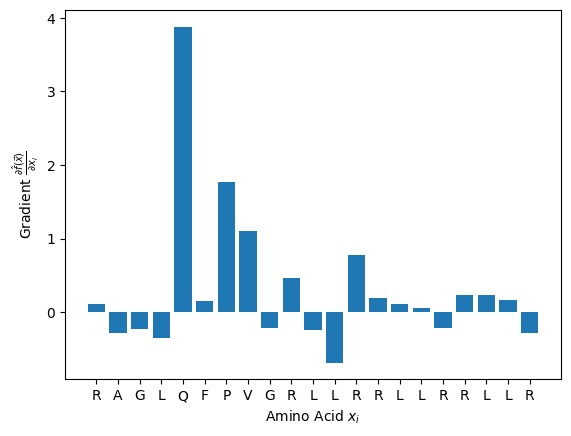

In [25]:
# we can view the individual Shapley values as:
plot_grad(sv, s)

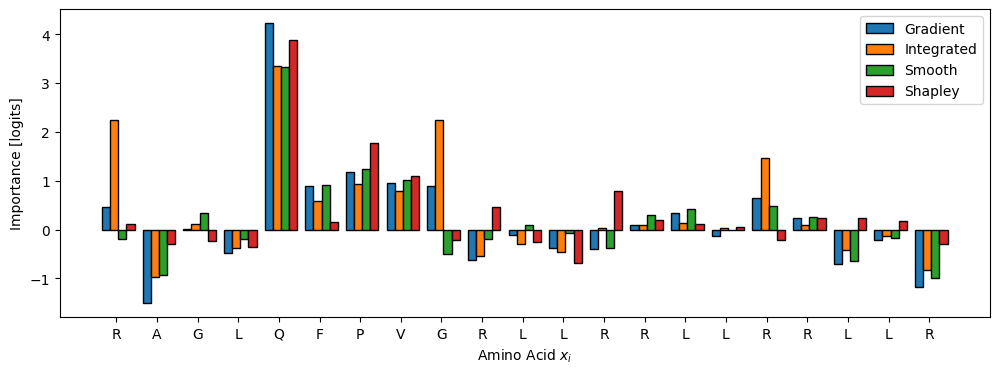

In [26]:
# we can compare the 4 methods side by side

heights = []
plt.figure(figsize=(12, 4))
x = np.arange(len(s))
for i, (gi, l) in enumerate(zip([g, ig, sg], ["Gradient", "Integrated", "Smooth"])):
    h = gi[0, np.arange(len(s)), list(map(ALPHABET.index, s))]
    plt.bar(x + i / 5 - 1 / 4, h, width=1 / 5, edgecolor="black", label=l)
plt.bar(x + 3 / 5 - 1 / 4, sv, width=1 / 5, edgecolor="black", label="Shapley")
ax = plt.gca()
ax.set_xticks(range(len(s)))
ax.set_xticklabels(s)
ax.set_xlabel("Amino Acid $x_i$")
ax.set_ylabel(r"Importance [logits]")
plt.legend()
plt.show()

We can thus draw out the conclusion as:

“The sequence is predicted to be hemolytic primarily because of the glutamine, proline, and arrangement of lecucine and arginine.”

Feature importance rarely leads to a clear explanation that gives the cause for a prediction or insight that is actionable. The lack of causality can lead us to find meaning in feature explanations that do not exist.

That is why we use actionable explanations that shows how to modify the features to affect the outcome- similar to saying we know the cause for an outcome

Another kind of explanation or interpretation we might desire is which training data points contribute most to a prediction. This is a more literal answer to the question: “Why did my model predict this?” – neural networks are a result of training data and thus the answer to why a prediction is made can be traced to training data. Ranking training data for a given prediction helps us understand which training examples are causing the neural network to predict a value.

Training data importance provides an interpretation that is useful for deep learning experts. It tells you which training examples are most influential for a given prediction. This can help troubleshoot issues with data or tracing explanations for spurious predictions.

We will be using counterfactuals for this. It minimises the point of interest such that we get a better model output, or in other words, it suggests the change required in data that can help us obtain a better result from our model. They use Manning distance criterion for it.

Counterfactuals have one disadvantage compared to Shapley values: they do not provide a complete explanation. Shapley values sum to the prediction, meaning we are not missing any part of the explanation. Counterfactuals modify as few features as possible (minimizing distance) and so may omit information about features that still contribute to a prediction. Of course, one advantage of Shapley values is that they are actionable. You can use the counterfactual directly.

In [27]:
def check_cf(x, i, j):
    # copy
    x = jnp.array(x)
    # substitute
    x = x.at[:, i].set(0)
    x = x.at[:, i, j].set(1)
    return predict(x)


check_cf(sm, 0, 0)

Array(8.551368, dtype=float32)

In [29]:
# we do it for all the possible substitutions using jnp.meshgrid

ii, jj = jnp.meshgrid(jnp.arange(sl), jnp.arange(21))
ii, jj = ii.ravel(), jj.ravel()
x = jax.vmap(check_cf, in_axes=(None, 0, 0))(sm, ii, jj)

In [30]:
# we’ll display all the single amino acid substitutions which resulted in a
# negative prediction - the logits are less than zero.

from IPython.core.display import display, HTML

out = ["<tt>"]
for i, j in zip(ii[jnp.squeeze(x) < 0], jj[jnp.squeeze(x) < 0]):
    out.append(f'{s[:i]}<span style="color:red;">{ALPHABET[j]}</span>{s[i+1:]}<br/>')
out.append("</tt>")
display(HTML("".join(out)))

We have a few to choose from, but the interpretation is essentially exchange the glutamine with a hydrophobic group or replace the proline with V, F, A, or C to make the peptide non-hemolytic. Stated as a counterfactual: “If the glutamine were exchanged with a hydrophobic amino acid, the peptide would not be hemolytic”.

The main challenge associated with counterfactuals in chemistry is the difficulty in computing the derivative in. Therefore, most methods which focus on this task are specific to model architectures as we saw previously. Wellawatte et. al [WSW22] have introduced a method named Molecular Model Agnostic Counterfactual Explanations (MMACE) to do this for molecules regardless of model architecture.

The MMACE method is implemented in the exmol package. Given a molecule and a model, exmol is able to generate local counterfactual explanations. There are two main steps involved in the MMACE method. First, a local chemical space is expanded around the given base molecule. Next, each sample point is labeled with the user given model architecture. These labels are then used to identify the counterfactuals in the local chemical space. As the MMACE method is model agnostic, exmol package is able to generate counterfactuals for both classification and regression tasks.

We will generate molecular counterfactuals using exmol. We will train a random forest model which predicts clinical toxicology of molecules. For this binary classification task, we’ll be using the same dataset by the MoleculeNet group

In [53]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import rdkit, rdkit.Chem, rdkit.Chem.Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import mordred, mordred.descriptors
import warnings
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

# from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import exmol

IPythonConsole.ipython_useSVG = True


toxdata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/main/data/clintox.csv.gz"
)

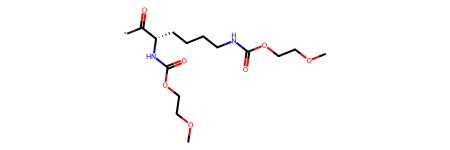

In [43]:
# make object that can compute descriptors
calc = mordred.Calculator(mordred.descriptors, ignore_3D=True)
# make subsample from pandas df
molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in toxdata.smiles]

# we view one molecule to make sure things look good.
molecules[0]

In [44]:
# Get valid molecules from the sample
valid_mol_idx = [bool(m) for m in molecules]
valid_mols = [m for m in molecules if m]
# Compute molecular descriptors using Mordred
features = calc.pandas(valid_mols, quiet=True)
labels = toxdata[valid_mol_idx].FDA_APPROVED
# Standardize the features
features -= features.mean()
features /= features.std()

# we have some nans in features, likely because std was 0
features = features.values.astype(float)
features_select = np.all(np.isfinite(features), axis=0)
features = features[:, features_select]
print(f"We have {len(features)} features per molecule")

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce


<ipython-input-44-4269f79f534e>:8: FutureWarning: The default value of numeric_only in MordredDataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  features -= features.mean()


We have 1480 features per molecule


We will use a simple dense neural network classifier implemented with keras

In [45]:
# Train and test spit
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, shuffle=True
)
ft_shape = X_train.shape[-1]

# reshape data
X_train = X_train.reshape(-1, ft_shape)
X_test = X_test.reshape(-1, ft_shape)

In [54]:
model = tf.keras.models.Sequential()
model.add(tf.keras.Input(shape=(ft_shape,)))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(32))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [55]:
# Model training
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
_, accuracy = model.evaluate(X_test, y_test)
print(f"Model accuracy: {accuracy:.2%}")

10/10 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.9493
Model accuracy: 94.93%


we’ll write a wrapper function that takes in SMILES and/or SELFIES molecule representations and output label predictions from the trained classifier. This wrapper function is given as an input to exmol.sample_space function in exmol to create a local chemical space around a given base molecule. exmol uses Superfast Traversal, Optimization, Novelty, Exploration and Discovery (STONED) algorithm as a generative algorithm to expand the local space. Given a base molecule, the STONED algorithm randomly mutate SELFIES representations of the molecules. These mutations can be string substitutions, additions or deletions.

In [56]:
def model_eval(smiles, selfies):
    molecules = [rdkit.Chem.MolFromSmiles(smi) for smi in smiles]
    features = calc.pandas(molecules)
    features = features.values.astype(float)
    features = features[:, features_select]
    labels = np.round(model.predict(np.nan_to_num(features).reshape(-1, ft_shape)))
    return labels

Now we use STONED to sample local chemical space with exmol.sample_space. We will modify the size of the sample space with num_samples argument. The base molecule selected here is a non-FDA approved molecule.

In [57]:
space = exmol.sample_space("C1CC(=O)NC(=O)C1N2CC3=C(C2=O)C=CC=C3N", model_eval)

100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


1/1 [==============================] - 0s 106ms/step


100%|██████████| 2515/2515 [10:06<00:00,  4.15it/s]


79/79 [==============================] - 0s 1ms/step


🤘Done🤘: 100%|██████████| 2515.0/2515 [00:10<00:00, 242.90it/s] 


Once the sample space is created, we can identify counterfactuals in the local chemical space using exmol.sample_space function. Each counterfactual is a python dataclass that contains additional information.

In [66]:
exps = exmol.cf_explain(space, 5)
exps

[Example(smiles='C1CC(=O)NC(=O)C1N1CC2=C(C1=O)C=CC=C2N', selfies='[C][C][C][=Branch1][C][=O][N][C][=Branch1][C][=O][C][Ring1][Branch2][N][C][C][=C][Branch1][Branch1][C][Ring1][Branch1][=O][C][=C][C][=C][Ring1][Branch2][N]', similarity=1.0, yhat=array(1., dtype=float32), index=0, position=array([-7.8088773 ,  1.01541569]), is_origin=True, cluster=-1, label=None, descriptors=None)]

We can easily visualize the generated counterfactuals using the plotting codes in exmol: exmol.sample_space and exmol.sample_space Similarity between the base and counterfactuals is the Tanimoto similarity of ECFP4 fingerprints. Top 3 counterfactuals are shown here:

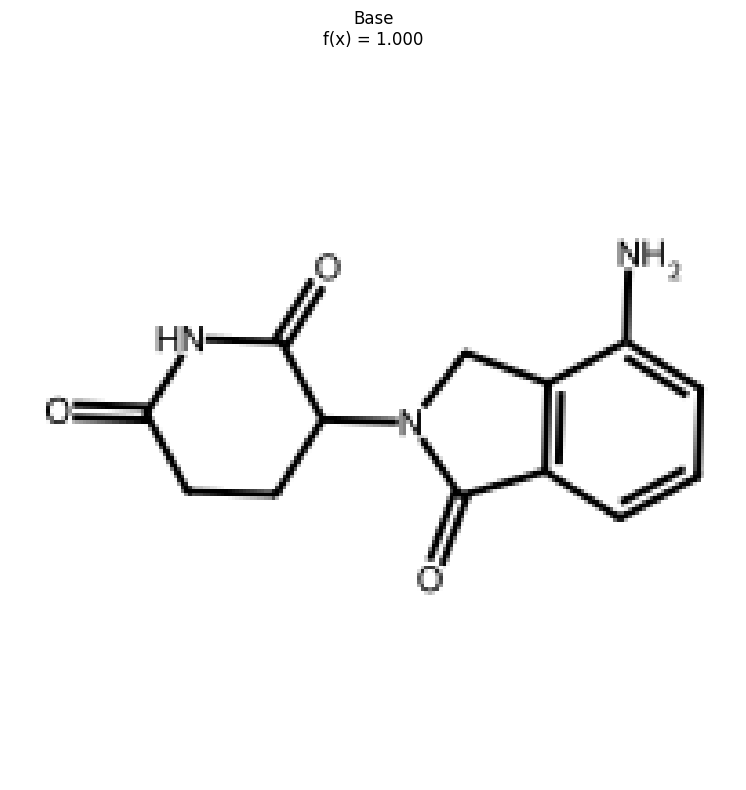

In [63]:
exmol.plot_cf(exps, nrows=1)

The base molecule which we selected here is NOT FDA approved. By looking at the generated counterfactuals we can conclude that, the heterocyclic group has an impact on the toxicity of the base. Therefore, by altering the heterocylic group, the base molecule might be made non-toxic according to our model. This also shows why counterfactual explanations give actionable insight into how modifications can be made.

We can also visualize the generated chemical space

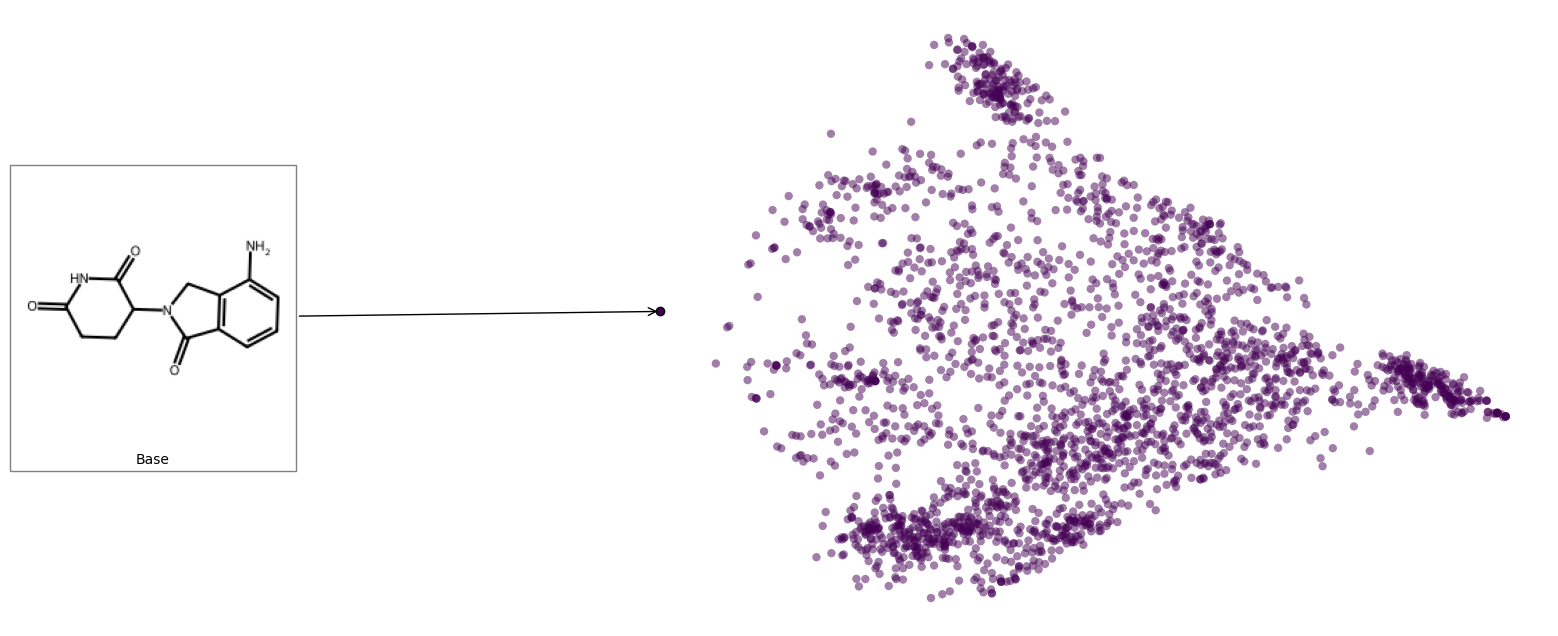

In [61]:
exmol.plot_space(space, exps)